In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import nltk
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sn

from text.process import text_processor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
    
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from keras.models import Sequential
from keras import layers

Using TensorFlow backend.


In [2]:

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    
def ajustar_tipo_documento(row):
    tipo = row['tipo']
    #corrige tipos que foram alterados no decorrer no tempo
    if tipo == 'Anexo 01 da LOA':
        return 'Anexo I da LOA – Anexo publicado junto à LOA do exercício em curso ou conforme o modelo disponibilizado'
    elif tipo == 'Certidão do TCE-PR':
        return 'Certidão do TCE-PR – Especifica para Operação de Crédito'
    elif tipo == 'Certidão negativa da Secretaria de Estado da Fazenda do Paraná':
        return 'Certidão SEFA - Certidão Negativa para Obtenção de novas operações de crédito'
    elif tipo == 'Parecer Jurídico do Município':
        return 'Parecer Juridico minuta edital'
    
    return tipo
    
def load_dataframe(csv_files):
    
    dataframes = []
    for csv_file in csv_files:
        dataframes.append(pd.read_csv(csv_file))
        
    df = pd.concat(dataframes, ignore_index=True, sort=False)
    
    # Remove documentação técnica do processo licitatório carregada erroneamente
    df = df[ 
            (df['tipo'] != 'Características técnicas') & 
            (df['tipo'] != 'Planilha de orçamento - Ganhadora') & 
            (df['tipo'] != 'Proposta comercial da empresa vencedora') &
            (df['tipo'] != 'Cronograma físico financeiro')
    ] 

    df.dropna()
    df['tipo'] = df.apply(ajustar_tipo_documento, axis=1)
    
    df['texto'] = df['texto'].astype(str).apply(lambda x: x.replace("\n", " "))
    df['texto_limpo'] = df['texto'].astype(str).apply(text_processor.clear_words)
    df['texto_stemmed'] = df['texto_limpo'].astype(str).apply(text_processor.stem_sentence)
    df['texto_len'] = df['texto'].astype(str).apply(len)
    df['texto_limpo_len'] = df['texto_limpo'].astype(str).apply(len)
    df['texto_stemmed_len'] = df['texto_stemmed'].astype(str).apply(len)
    df['qtd_palavras_texto'] = df['texto'].apply(lambda x: len(str(x).split()))
    df['qtd_palavras_texto_limpo'] = df['texto_limpo'].apply(lambda x: len(str(x).split()))
    df['qtd_palavras_texto_stemmed'] = df['texto_stemmed'].apply(lambda x: len(str(x).split()))

    return df
    # Remove documentos da parte técnica
    # df = df[ (df['tipo'] != 'Características técnicas') & (df['tipo'] != 'Planilha de orçamento - Ganhadora') & (df['tipo'] != 'Edital de classificação')] 

#     df['tipo'] = df['tipo'].astype(str).apply(lambda x: x if x != 'Anexo 01 da LOA' else 'Anexo I da LOA – Anexo publicado junto à LOA do exercício em curso ou conforme o modelo disponibilizado')
#     df['tipo'] = df['tipo'].astype(str).apply(lambda x: x if x != 'Certidão do TCE-PR' else 'Certidão do TCE-PR – Especifica para Operação de Crédito')
#     df['tipo'] = df['tipo'].astype(str).apply(lambda x: x if x != 'Certidão negativa da Secretaria de Estado da Fazenda do Paraná' else 'Certidão SEFA - Certidão Negativa para Obtenção de novas operações de crédito')



In [3]:
RANDOM_STATE = 42
DATAFRAME_PATH = [
    '/home/cti/workspace/cls_documento/dataset/dataframe/dataframe_operacao_credito.csv',
    '/home/cti/workspace/cls_documento/dataset/dataframe/dataframe_processo_licitatorio.csv',
]

df = load_dataframe(DATAFRAME_PATH)

n_classes = len(df.tipo.unique())

print('Num Classes: {}'.format(n_classes))
df.sample(5)

Num Classes: 22


Unnamed: 0                                            projeto  \
394          25                Bandeirantes - proj 64 - processo 1   
301         301  Santa Cruz do Monte Castelo - Operação de Créd...   
256         256                  Rolândia - Operação de Crédito 18   
539         170                    Icaraíma - proj 50 - processo 1   
676         307          São Carlos do Ivaí - proj 28 - processo 1   

                                                 texto  \
394  PREFEITURA MUNICIPAL DE BANDEIRANTES ESTADO DO...   
301  Estado do Paraná     LEI Nº 346/2019  AUTORIZA...   
256  TRIBUNAL DE CONTAS DO ESTADO DO PARANÁ Diretor...   
539  PREFEITURA MUNICIPAL DE ICARAÍMA ESTADO DO PAR...   
676  VAMADIESEL COMÉRCIO DE MÁQUINAS - REU ENDEREÇO...   

                                                  tipo  \
394                     Parecer Juridico minuta edital   
301                                   Lei Autorizadora   
256  Certidão do TCE-PR – Especifica para Operação ...   
539             Declaração de inexistência de recursos   
676                            Edital de classificação   

                                         modulo  \
394  ../../dataset/imagens/processo_licitatorio   
301                            operacao_credito   
256                            operacao_credito   
539  ../../dataset/imagens/processo_licitatorio   
676  ../../dataset/imagens/processo_licitatorio   

                                           texto_limpo  \
394  prefeitura municipal bandeirantes estado paran...   
301  estado paraná lei 346/2019 autoriza executivo ...   
256  tribunal contas estado paraná diretoria-geral ...   
539  prefeitura municipal icaraíma estado paraná cn...   
676  vamadiesel comércio máquinas reu endereço rodo...   

                                         texto_stemmed  texto_len  \
394  prefeit municip bandeir est paran parec juríd ...       5485   
301  est paran lei 346/2019 autoriz execu municip c...       3370   
256  tribun cont est paran diretoria-ger cert oper ...       5158   
539  prefeit municip icaraím est paran cnpj 247 337...        742   
676  vamadiesel comérci máquin reu endereç rodov 27...       5730   

     texto_limpo_len  texto_stemmed_len  qtd_palavras_texto  \
394             4277               3223                 795   
301             2488               1833                 529   
256             3618               2844                 777   
539              556                437                 102   
676             4369               3749                 883   

     qtd_palavras_texto_limpo  qtd_palavras_texto_stemmed  
394                       482                         482  
301                       297                         297  
256                       450                         450  
539                        63                          63  
676                       562                         562

In [4]:
# encoder = LabelEncoder()
encoder = OneHotEncoder(sparse=False)
X = df.texto_limpo.values
# X = df.texto_stemmed.values
y = encoder.fit_transform(df.tipo.values.reshape(len(df.tipo.values), 1))

# vectorizer = CountVectorizer(token_pattern=r'\w{3,}')
# vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', ngram_range=(2,3), max_features=5000)
vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', max_features=5000)
vectorizer.fit( X )
X = vectorizer.transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

X_train = X
y_train = y

input_dim = X_train.shape[1]
print(input_dim)
print(len(df.tipo.values))
# print(df.tipo.values)
print(y.shape)

5000
748
(748, 22)


In [5]:

model = Sequential()
model.add(layers.Dense(8, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())


# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.BatchNormalization())


# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.BatchNormalization())

model.add(layers.Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 40008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 22)                198       
Total params: 40,238
Trainable params: 40,222
Non-trainable params: 16
_________________________________________________________________


In [6]:
# history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
748/748 [==============================] - 1s 1ms/step - loss: 2.7110 - acc: 0.2660
Epoch 2/50
748/748 [==============================] - 0s 99us/step - loss: 2.1857 - acc: 0.5628
Epoch 3/50
748/748 [==============================] - 0s 95us/step - loss: 1.9896 - acc: 0.6524
Epoch 4/50
748/748 [==============================] - 0s 102us/step - loss: 1.8599 - acc: 0.6778
Epoch 5/50
748/748 [==============================] - 0s 96us/step - loss: 1.7493 - acc: 0.6751
Epoch 6/50
748/748 [==============================] - 0s 95us/step - loss: 1.6707 - acc: 0.6925
Epoch 7/50
748/748 [==============================] - 0s 97us/step - loss: 1.6164 - acc: 0.6898
Epoch 8/50
748/748 [==============================] - 0s 103us/step - loss: 1.5243 - acc: 0.7032
Epoch 9/50
748/748 [==============================] - 0s 96us/step - loss: 1.4277 - acc: 0.7179
Epoch 10/50
748/748 [==============================] - 0s 116us/step - loss: 1.3872 - acc: 0.7099
Epoch 11/50
748/748 [================

In [ ]:
plot_history(history)

Acc Treino: 0.9519


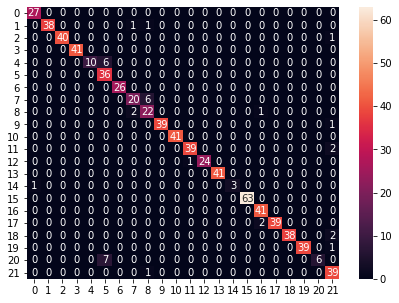

In [7]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Acc Treino: {:.4f}".format(accuracy))

# loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
# print("Acc Teste:  {:.4f}".format(accuracy))


# y_pred = model.predict(X_test)
# cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

y_pred = model.predict(X_train)
cm = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))


df_cm = pd.DataFrame(cm)
plt.figure(figsize = (7, 5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [37]:
index_test = 123
X_valid = df.iloc[index_test].texto_limpo
X_valid = vectorizer.transform([X_valid])

predicted = model.predict(X_valid)
print(predicted)
print(predicted[0].max())
print(predicted[0][predicted[0].argmax(axis=-1)])

print(predicted.argmax(axis=-1))
print( encoder.inverse_transform(predicted) )
print( encoder.inverse_transform( np.array(predicted[0]).reshape(1, -1) )[0][0] )

print(df.iloc[index_test].tipo)

[[3.2138524e-03 1.4849759e-03 4.2540401e-06 2.1398489e-06 2.0359200e-04
  3.3371150e-04 1.2618671e-04 2.3847104e-04 1.5880595e-04 7.9731857e-03
  8.7785003e-05 9.7380936e-01 4.0305052e-03 4.3500736e-03 3.4986611e-04
  1.5184371e-04 2.7661737e-05 1.2269649e-03 6.9145183e-04 1.6755721e-05
  3.9759841e-05 1.4789072e-03]]
0.97380936
0.97380936
[11]
[['Lei Autorizadora']]
['Lei Autorizadora']
Lei Autorizadora


In [9]:

tipos = sorted(df.tipo.unique())

i = 0
for tipo in sorted(tipos):
    print('{} - {}'.format(i, tipo))
    encode = encoder.transform( np.array([tipo]).reshape(1, -1) )
    print(encode[0])
    i += 1


0 - Anexo I da LOA – Anexo publicado junto à LOA do exercício em curso ou conforme o modelo disponibilizado
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 - Atas do Processo Licitatório
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 - Certidão SEFA - Certidão Negativa para Obtenção de novas operações de crédito
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 - Certidão do TCE-PR – Especifica para Operação de Crédito
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 - Declaração das proponentes declinando do prazo recursal
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 - Declaração de inexistência de recursos
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 - Decreto de abertura de crédito adicional
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7 - Edital de classificação
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [20]:
import pickle
# pickle.dump(vectorizer.vocabulary_, open("operacao_credito_processo_licitatorio_juridico.pkl", "wb"))
# vectorizer.vocabulary_

# model.save_weights('tiny_rna.h5')

encoder.categories_
pickle.dump(encoder.categories_, open("classes_operacao_credito_processo_licitatorio_juridico.pkl", "wb"))